In [8]:
import os
import cv2
import numpy as np

# Updated paths for train and test directories
train_dir = 'D:\\facefusion2.0\\train'
test_dir = 'D:\\facefusion2.0\\test'

# Emotion classes as per FER2013 dataset
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Engaged and Not Engaged Classification
engaged = ['neutral', 'happy', 'surprise']
not_engaged = ['angry', 'disgust', 'fear', 'sad']

def load_and_preprocess_images(data_dir):
    images = []
    labels = []

    for emotion in emotion_labels:
        folder_path = os.path.join(data_dir, emotion)
        label = 1 if emotion in engaged else 0  # 1: engaged, 0: not engaged
        
        # Ensure the folder exists
        if os.path.exists(folder_path):
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    # Resize images to 48x48 pixels (FER2013 image size)
                    image = cv2.resize(image, (48, 48))
                    images.append(image)
                    labels.append(label)
        else:
            print(f"Directory {folder_path} not found")
    
    images = np.array(images)
    labels = np.array(labels)
    
    # Normalize pixel values (0-255) to (0-1)
    images = images / 255.0

    # Reshape to (num_images, 48, 48, 1) for CNN input
    images = images.reshape(images.shape[0], 48, 48, 1)
    
    return images, labels

# Load train and test datasets
X_train, y_train = load_and_preprocess_images(train_dir)
X_test, y_test = load_and_preprocess_images(test_dir)


In [9]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding for binary classification
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn_model():
    model = Sequential()

    # First Convolution Layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolution Layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolution Layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Fully Connected Layer
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))  # Dropout for regularization
    model.add(Dense(2, activation='softmax'))  # Output for engaged/not engaged

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build the model
cnn_model = create_cnn_model()

# Print model summary
cnn_model.summary()


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 355,202 (1.35 MB)

 Trainable params: 355,202 (1.35 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
history = cnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)

# Save the model for future use
cnn_model.save('facefusion_cnn_model.h5')


Epoch 1/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 44s 88ms/step - accuracy: 0.5519 - loss: 0.6857 - val_accuracy: 0.6272 - val_loss: 0.6471
Epoch 2/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 39s 86ms/step - accuracy: 0.6509 - loss: 0.6251 - val_accuracy: 0.6959 - val_loss: 0.5725
Epoch 3/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 73s 164ms/step - accuracy: 0.7163 - loss: 0.5503 - val_accuracy: 0.7229 - val_loss: 0.5321
Epoch 4/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 142s 315ms/step - accuracy: 0.7454 - loss: 0.5061 - val_accuracy: 0.7353 - val_loss: 0.5205
Epoch 5/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 146s 325ms/step - accuracy: 0.7608 - loss: 0.4797 - val_accuracy: 0.7407 - val_loss: 0.5113
Epoch 6/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 136s 302ms/step - accuracy: 0.7762 - loss: 0.4545 - val_accuracy: 0.7530 - val_loss: 0.5000
Epoch 7/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 93s 207ms/step - accuracy: 0.8000 - loss: 0.4232 - val_accuracy: 0.7615 - val_loss: 0.4932
Epoch 8/20
449/449 ━━━━━━━━━━━━━━━━━━━━ 97s 217ms/step - accuracy: 0.8134 - loss: 

In [12]:
# Evaluate on test set
test_loss, test_acc = cnn_model.evaluate(X_test, y_test, verbose=2)
print(f'Test accuracy: {test_acc * 100:.2f}%')


225/225 - 5s - 21ms/step - accuracy: 0.7671 - loss: 0.8150
Test accuracy: 76.71%


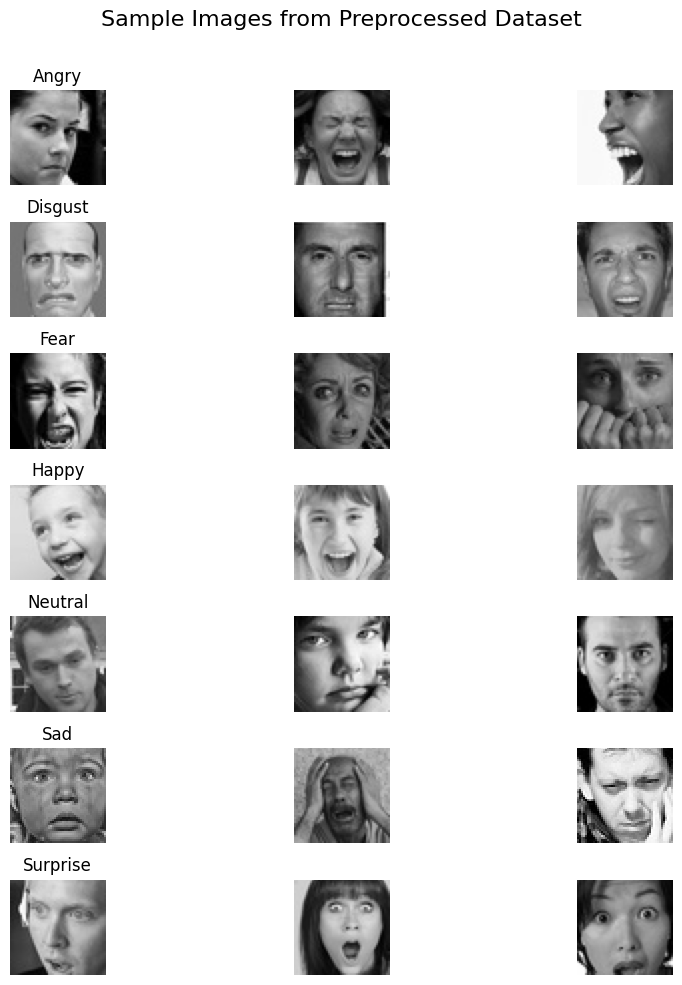

In [13]:
import matplotlib.pyplot as plt
import os
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the preprocessed dataset
dataset_path = 'D:\\facefusion2.0\\train'

# Emotion categories (folders)
categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

def plot_samples(dataset_path, categories, samples_per_category=3):
    fig, axes = plt.subplots(len(categories), samples_per_category, figsize=(10, 10))
    fig.suptitle('Sample Images from Preprocessed Dataset', fontsize=16)

    for i, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        sample_images = random.sample(os.listdir(category_path), samples_per_category)
        
        for j, img_file in enumerate(sample_images):
            img_path = os.path.join(category_path, img_file)
            img = load_img(img_path, target_size=(48, 48))  # Modify target_size based on your preprocessing
            img_array = img_to_array(img)

            # Plot the image
            axes[i, j].imshow(img_array.astype("uint8"))
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_title(category.capitalize())
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Plot random samples from the preprocessed dataset
plot_samples(dataset_path, categories)


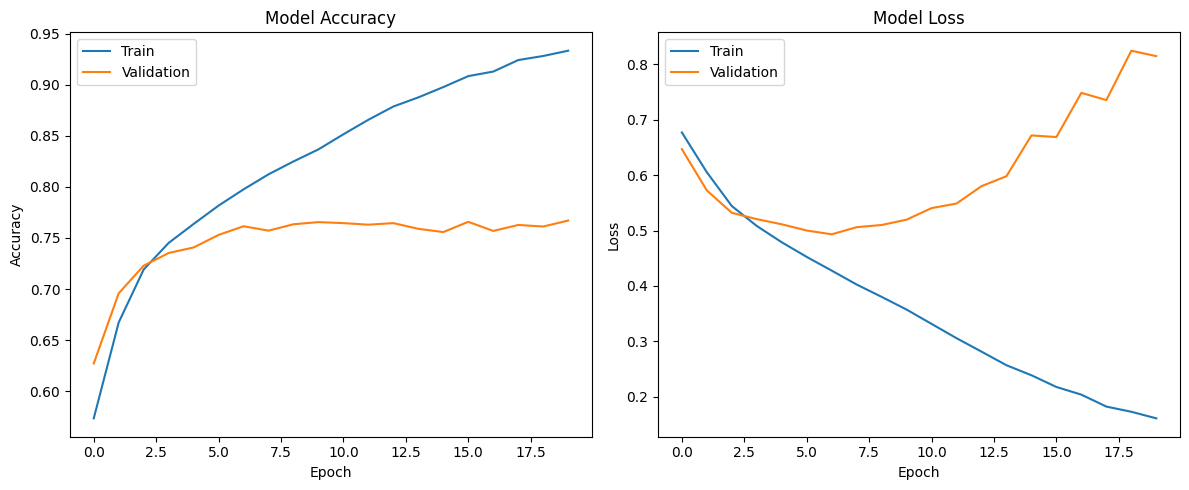

In [14]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable storing the training process from model.fit()
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Call this function after model training
# history = model.fit(....)
plot_training_history(history)
